# Tip: Natural Language Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils, plot_help
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
import nltk

import re


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

%matplotlib inline

In [2]:
#modify read_limit and chunk_size parameters based on memory capacity
df = utils.chunk_loader('data/tip.json', read_limit=10000)
df.head()

,business_id,compliment_count,date,text,user_id
0,VaKXUpmWTTWDKbpJ3aQdMw,0,2014-03-27 03:51:24,"Great for watching games, ufc, and whatever el...",UPw5DWs_b-e2JRBS-t37Ag
1,OPiPeoJiv92rENwbq76orA,0,2013-05-25 06:00:56,Happy Hour 2-4 daily with 1/2 price drinks and...,Ocha4kZBHb4JK0lOWvE0sg
2,5KheTjYPu1HcQzQFtm4_vw,0,2011-12-26 01:46:17,Good chips and salsa. Loud at times. Good serv...,jRyO2V1pA4CdVVqCIOPc1Q
3,TkoyGi8J7YFjA6SbaRzrxg,0,2014-03-23 21:32:49,The setting and decoration here is amazing. Co...,FuTJWFYm4UKqewaosss1KA
4,AkL6Ous6A1atZejfZXn1Bg,0,2012-10-06 00:19:27,Molly is definately taking a picture with Sant...,LUlKtaM3nXd-E4N4uOk_fQ


In [3]:
df.shape

(10000, 5)

In [4]:
df.dtypes

business_id                 object
compliment_count             int64
date                datetime64[ns]
text                        object
user_id                     object
dtype: object

In [5]:
df['text'][42]

'Lots of people on the second floor!'

In [6]:
text_len = [len(x) for x in df['text']]

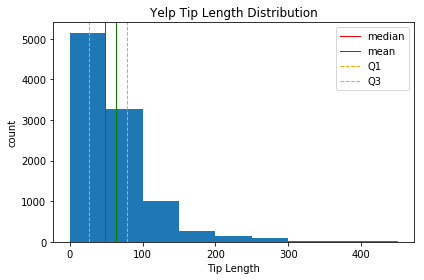

In [7]:
plot_help.plot_hist(pd.Series(text_len),end=500, step=50,
                    feature='Tip Length', xlabel='Tip Length',
                    saveloc='plots/tip_length.png')

In [8]:
df.nunique()

business_id         7783
compliment_count       5
date                9999
text                9939
user_id             5996
dtype: int64

In [9]:
df.compliment_count.value_counts()

0    9816
1     164
2      16
3       3
4       1
Name: compliment_count, dtype: int64

### Word Cloud

In [10]:
#Combine all the reviews into one massive string
review_text_combined = " ".join(review for review in df['text'])
print ("There are {} words in the combination of all reviews.".format(len(review_text_combined)))

There are 639623 words in the combination of all reviews.


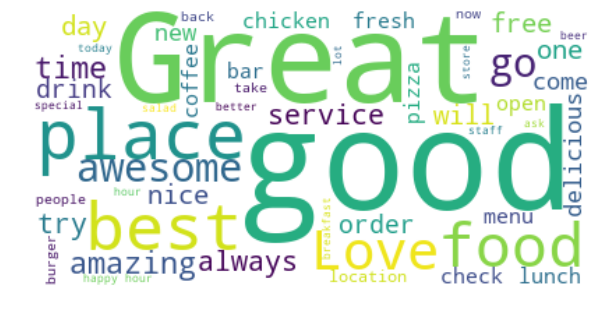

In [11]:
# Create stopword list:
stopwords = set(STOPWORDS)
#For now let's only remove the
stopwords.update(["the"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      width= 400, height = 200, 
                      max_words=50).generate(review_text_combined)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('plots/tip_word_cloud.png')
plt.show()

### Bag of Words

In [12]:
#instantiate the countvectorizer and assume minimum frequenct is 3
vect = CountVectorizer(min_df=3, stop_words="english")

#fit the corpus
vect.fit(df['text'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
print("Vocab size = {}".format(len(vect.vocabulary_)))

Vocab size = 3271


In [14]:
#create bag of words
bag_of_words = vect.transform(df['text'])

In [15]:
#number of features to see
k=20
feature_names = vect.get_feature_names()
print("Number of features = {}".format(len(feature_names)))
print("First {} features: \n{}".format(k, feature_names[:k]))

Number of features = 3271
First 20 features: 
['00', '000', '00am', '00pm', '08', '09', '10', '100', '10am', '10p', '10pm', '11', '11am', '11pm', '12', '12pm', '13', '14', '14th', '15']


### tf-idf

In [16]:
def stem_sentences(sentence):
    
    """
    Helper function to stem text with PorterStemmber and Lemmatizer
    """
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer() 
    
    tokens = sentence.split()
    
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    
    lemmed_tokens = [lemmatizer.lemmatize(token, pos='n') for token in stemmed_tokens]
    lemmed_tokens = [lemmatizer.lemmatize(token, pos='v') for token in lemmed_tokens]
    
    return ' '.join(lemmed_tokens)

In [17]:
with open('french_stop_words.txt') as f:
    french_stop_words = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
french_stop_words = [x.strip() for x in french_stop_words] 

In [18]:
#french words to remove
fr_pat = r'\b(?:{})\b'.format('|'.join(french_stop_words))

#take out french words
text_no_fr = df['text'].str.replace(fr_pat, '')

#create a stemmed version of review text
text_stem = df['text'].apply(stem_sentences)

In [19]:
#instantiate tfidf object
tfidf = TfidfVectorizer(stop_words="english", min_df=2).fit(text_stem)

#transform and fit text
tfidf_text = tfidf.transform(text_stem)

In [20]:
#get feature array
feature_array = np.array(tfidf.get_feature_names())

#get sorted indeces
tfidf_sorting = np.argsort(tfidf_text.toarray()).flatten()[::-1]

k_tfidf = 20
print("{} features with HIGHEST tifdf: \n{}".format(k_tfidf, feature_array[tfidf_sorting][:k_tfidf]))
print("{} features with LOWEST tifdf: \n{}".format(k_tfidf, feature_array[tfidf_sorting][-k_tfidf:]))


20 features with HIGHEST tifdf: 
['cornbread' 'crispi' 'prepar' 'larg' 'portion' 'chicken' 'love' 'food'
 'zumba' 'existence' 'excus' 'execut' 'exhibit' 'exist' 'exot' 'exit'
 'expand' 'expect' 'expectations' 'expens']
20 features with LOWEST tifdf: 
['pizzas' 'pizza' 'pix' 'piti' 'pigout' 'pitcher' 'pita' 'pit' 'pistachio'
 'piss' 'pipe' 'pint' 'pinot' 'pink' 'pineappl' 'pinay' 'pin' 'pile'
 'pilat' '00']
